In [77]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [78]:
result_path = '/data/coding/chaochuan/TSGym/meta/results'
# file_list = os.listdir(result_path)
file_list = ['perf_epoch_ETTm1.npz',
             'perf_epoch_ETTm2.npz',
             'perf_epoch_ETTh1.npz',
             'perf_epoch_ETTh2.npz',
             'perf_epoch_ili.npz',
             'perf_epoch_weather.npz',
             'perf_epoch_ECL.npz',
             'perf_epoch_Exchange.npz',
             'perf_epoch_traffic.npz']
print(len(file_list))

9


In [79]:
# sota performance
def search_sota_performance(dataset, pred_lens=[96], path = '/data/coding/chaochuan/TSGym/results'):
    result_dict = {}
    for pred_len in pred_lens:
        model_list = os.listdir(path)
        model_list = [_ for _ in model_list if f'pl{pred_len}' in _ and dataset in _]
        result_dict[pred_len] = {}
        for model in model_list:
            result = np.load(os.path.join(path, model, 'metrics.npy'), allow_pickle=True)
            result_dict[pred_len][model] = result[1]

    df = pd.DataFrame.from_dict(result_dict[pred_lens[0]], orient='index')
    df.columns = ['mse']
    df = df.sort_values(by='mse')
    df.index = [_.split('_')[6] for _ in df.index]

    return df

In [80]:
# file_list = ['perf_epoch_ETTh2.npz','perf_epoch_Exchange.npz','perf_epoch_ili.npz','perf_epoch_weather.npz',
#               'perf_epoch_ETTm1.npz','perf_epoch_ETTh1.npz','perf_epoch_ETTm2.npz', 'perf_epoch_ECL.npz',
#             'perf_epoch_traffic.npz']

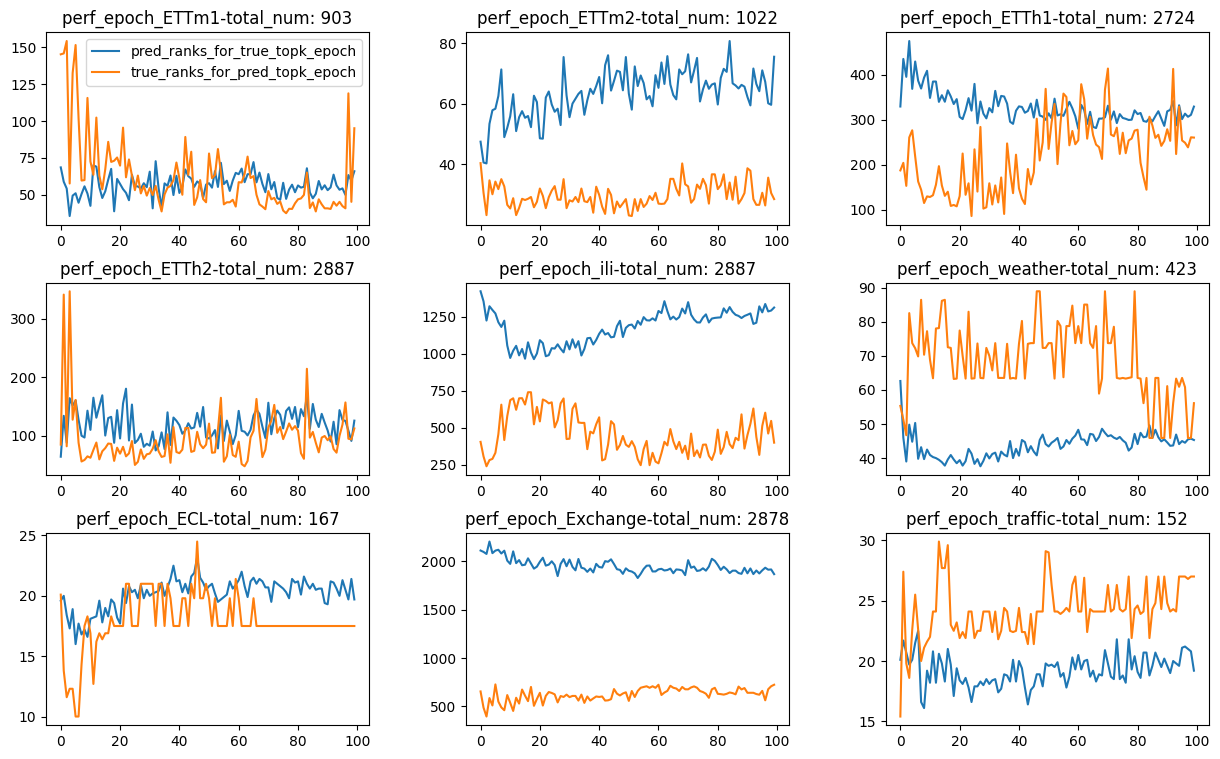

In [81]:
fig = plt.figure(figsize=(15, 9))
for i, file in enumerate(file_list):
    try:
        perf_epoch = np.load(os.path.join(result_path, file), allow_pickle=True)
        # print(perf_epoch.files)

        fig.add_subplot(3, 3, i+1)
        for _ in perf_epoch.files:
            if _ in ['pred_ranks_for_true_topk_epoch', 'true_ranks_for_pred_topk_epoch']:
                plt.plot(perf_epoch[_], label=_)
            elif _ == 'total_num':
                plt.title(f'{file.replace(".npz", "")}-total_num: {perf_epoch[_]}')
            else:
                pass 

        if i==0: plt.legend()
    except:
        continue

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

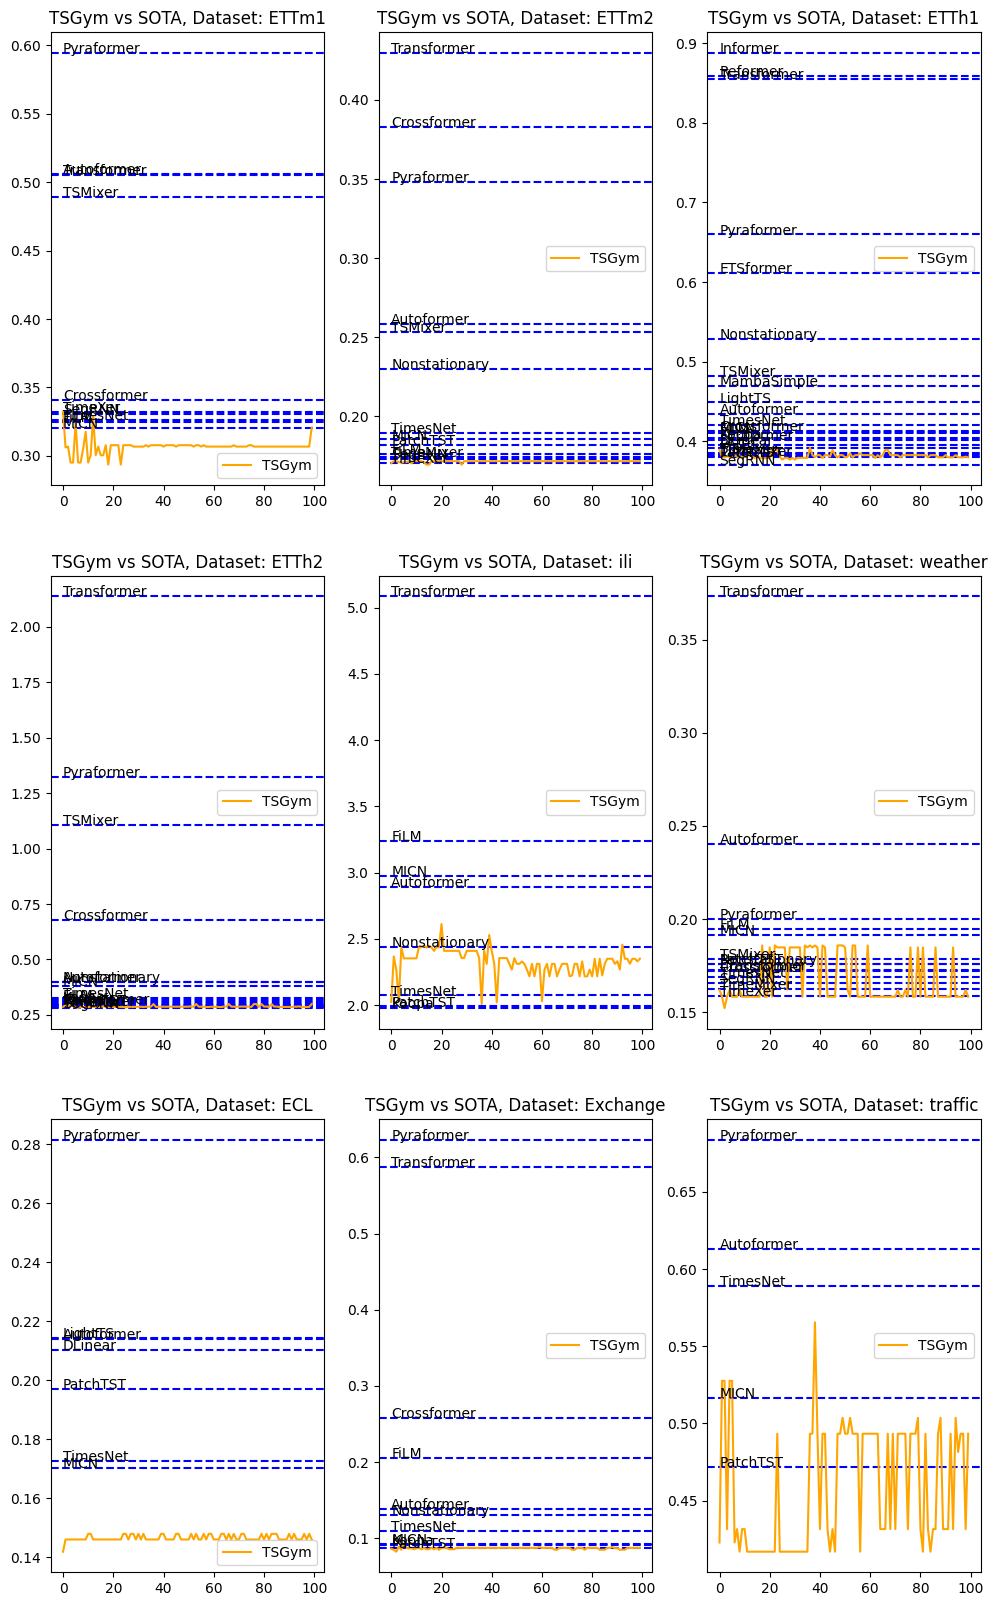

In [82]:
fig = plt.figure(figsize=(12, 20))
for i, file in enumerate(file_list):
    try:
        dataset = file.split('_')[-1].replace('.npz', '')
        # todo: ILI数据集和Gym不一致
        # try:
        if dataset == 'ili':
            df = search_sota_performance(dataset, pred_lens=[60])
        else:
            df = search_sota_performance(dataset)
        # except:
        #     continue
        fig.add_subplot(3, 3, i+1)
        for model, metric in df.iterrows():
            plt.axhline(y=metric.item(), color='blue', linestyle='--')
            plt.text(0, metric.item(), model, color='black')

        # 添加图例和标题
        perf_epoch = np.load(os.path.join(result_path, file), allow_pickle=True)
        top1_perf_epoch = perf_epoch['top1_perf_epoch']
        plt.plot(top1_perf_epoch, color='orange', label='TSGym')

        plt.legend()
        plt.title(f'TSGym vs SOTA, Dataset: {dataset}')
    except:
        continue

plt.show()

meta-feature的差异性

In [83]:
meta_feature_path = '/data/coding/chaochuan/TSGym/meta_learner_cc/meta_feature_copy/meta_feature'

In [84]:
meta_features_dict = {}
for file in os.listdir(meta_feature_path):
    if file.endswith('.npz'):
        meta_feature = np.load(os.path.join(meta_feature_path, file), allow_pickle=True)
        meta_features_dict[file.replace('.npz', '').replace('meta_feature_', '')] = meta_feature['meta_feature']

In [85]:
meta_features = np.stack(list(meta_features_dict.values()))
meta_features = np.clip(meta_features, -1e4, 1e4)

# z-score
mu = np.nanmean(meta_features, axis=0, keepdims=True)
std = np.nanstd(meta_features, axis=0, keepdims=True)

meta_features = (meta_features - mu) / (std + 1e-6)
meta_features = np.nan_to_num(meta_features, nan=0.0)

In [86]:
# fig = plt.figure(figsize=(20, 20))

# for seed in range(1, 5):
#     tsne = TSNE(n_components=2, random_state=seed, perplexity=10)
#     meta_features_tsne = tsne.fit_transform(meta_features) 
#     meta_features_dict_tsne = {k: v for k, v in zip(meta_features_dict.keys(), meta_features_tsne)}
#     fig.add_subplot(2, 2, seed)
#     for k, v in meta_features_dict_tsne.items():
#         plt.scatter(v[0], v[1])
#         plt.text(v[0], v[1], k, fontsize=12)
# fig.suptitle('TSNE', fontsize=16)
# plt.show()


In [87]:
# fig = plt.figure(figsize=(20, 20))

# pca = PCA(n_components=2, random_state=42)
# meta_features_pca = pca.fit_transform(meta_features) 
# meta_features_dict_pca = {k: v for k, v in zip(meta_features_dict.keys(), meta_features_pca)}
# for k, v in meta_features_dict_pca.items():
#     plt.scatter(v[0], v[1])
#     plt.text(v[0], v[1], k, fontsize=16)
# plt.title('PCA', fontsize=16)
# plt.show()
